In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [12]:
import argparse
import pandas as pd
import lightgbm as lgb
import joblib
from sklearn.preprocessing import StandardScaler
import copy
# import random
import itertools
from sklearn.impute import SimpleImputer
import numpy as np

In [13]:
def preprocess_data(df):
    # # 假设需要对数据进行标准化
    # scaler = StandardScaler()
    # data_scaled = scaler.fit_transform(data)
    # Count the frequency of k-mer in each RNA sequence
        # k-mer was normalized by total k-mer count of each RNA sequence
    def _count_kmer(Dataset, k):  # k = 3, 4, 5
        
        # copy dataset
        dataset = copy.deepcopy(Dataset)
        # alphabet of nucleotide
        nucleotide = ['A', 'C', 'G', 'T']
        
        # generate k-mers
        #  k == 5:
        five = list(itertools.product(nucleotide, repeat=5))
        pentamer = [''.join(n) for n in five]
        
        #  k == 4:
        four = list(itertools.product(nucleotide, repeat=4))
        tetramer = [''.join(n) for n in four]

        # k == 3:
        three = list(itertools.product(nucleotide, repeat=3))
        threemer = [''.join(n) for n in three]
        
        # input features can be combinations of different k values
        if k == 34:
            table_kmer = dict.fromkeys(threemer, 0)
            table_kmer.update(dict.fromkeys(tetramer, 0))
        elif k == 45:
            table_kmer = dict.fromkeys(tetramer, 0)
            table_kmer.update(dict.fromkeys(pentamer, 0))
        elif k == 345:
            table_kmer = dict.fromkeys(threemer, 0)
            table_kmer.update(dict.fromkeys(tetramer, 0))
            table_kmer.update(dict.fromkeys(pentamer, 0))

        # count k-mer for each sequence
        for mer in table_kmer.keys():
            table_kmer[mer] = dataset["sequence"].apply(lambda x: x.count(mer))
        
        # for k-mer raw count without normalization, index: nuc:1 or cyto:0
        rawcount_kmer_df = pd.DataFrame(table_kmer)
        df1_rawcount = pd.concat([rawcount_kmer_df, dataset["name"]], axis=1)
        df1_rawcount.index = dataset["tag"]

        # for k-mer frequency with normalization, index: nuc:1 or cyto:0
        freq_kmer_df = rawcount_kmer_df.apply(lambda x: x / x.sum(), axis=1)
        df1 = pd.concat([freq_kmer_df, dataset["name"]], axis=1)
        df1.index = dataset["tag"]

        return df1, df1_rawcount

    df_kmer_test, df_kmer_test_raw = _count_kmer(df, 345)
    del df_kmer_test['name']
    x_kmer = df_kmer_test.values
    imputer = SimpleImputer(strategy='mean')
    x_test = imputer.fit_transform(x_kmer)
    # y_test = np.array(df_kmer_test.index)

    return x_test

In [14]:
def load_model(model_path):
    model = joblib.load(model_path)
    return model

In [15]:
def predict(model, x_test, df):
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:,1]
    df['prediction'] = y_pred  # 添加预测标签列
    df['prob'] = y_prob  # 添加预测概率列

    evaluate_df = df

    auroc = roc_auc_score(evaluate_df["tag"], evaluate_df["prob"])
    accuracy = accuracy_score(evaluate_df['tag'], evaluate_df['prediction'])
    sensitivity = recall_score(evaluate_df['tag'], evaluate_df['prediction'])  # Sensitivity = True Positive Rate
    specificity = recall_score(evaluate_df['tag'], evaluate_df['prediction'], pos_label=0)  # Specificity = True Negative Rate
    f1 = f1_score(evaluate_df['tag'], evaluate_df['prediction'])
    print(f"AUROC: {auroc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return evaluate_df

In [16]:
def parse_fasta_to_dataframe(fasta_path):
    records = []
    with open(fasta_path, 'r') as file:
        name, position, seq_lines = None, None, []
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if name:
                    sequence = ''.join(seq_lines)
                    tag = 0 if position in ['Nucleus', 'Cytosol'] else 1
                    records.append({'name': name, 'position': position, 'sequence': sequence, 'tag': tag})
                # 处理新的记录
                header_parts = line[1:].split()
                name = header_parts[0]
                position = header_parts[1] if len(header_parts) > 1 else 'Unknown'
                seq_lines = []
            else:
                seq_lines.append(line)
        # 添加最后一条记录
        if name:
            sequence = ''.join(seq_lines)
            tag = 0 if position in ['Nucleus', 'Cytosol'] else 1
            records.append({'name': name, 'position': position, 'sequence': sequence, 'tag': tag})
    
    return pd.DataFrame(records)

In [17]:
model = load_model('/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/circExor/models/saved_models/circRNA_ML_Model_Output/LightGBM/best_LightGBM_model.pkl')
df = parse_fasta_to_dataframe('/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/python_scripts/ML_models/circRNA_ML_Model_Output/test_set_sequences1.fasta')
x_test = preprocess_data(df)
evaluate_df = predict(model, x_test, df)


/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


AUROC: 0.8285
Accuracy: 0.8140
Sensitivity: 0.6000
Specificity: 0.8654
F1 Score: 0.5556


/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


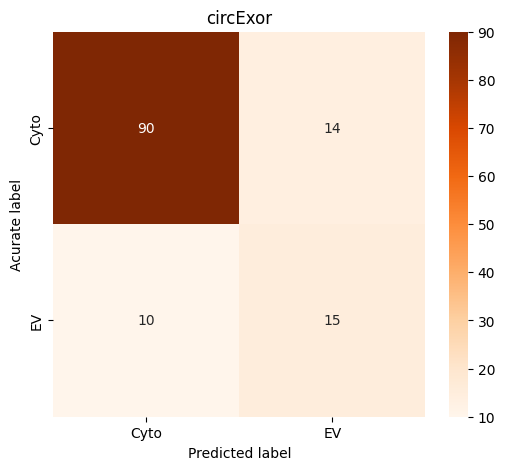

In [19]:
cm = confusion_matrix(evaluate_df['tag'], evaluate_df['prediction'])

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cyto', 'EV'], yticklabels=['Cyto', 'EV'])
plt.title('circExor')
plt.ylabel('Acurate label')
plt.xlabel('Predicted label')
plt.show()

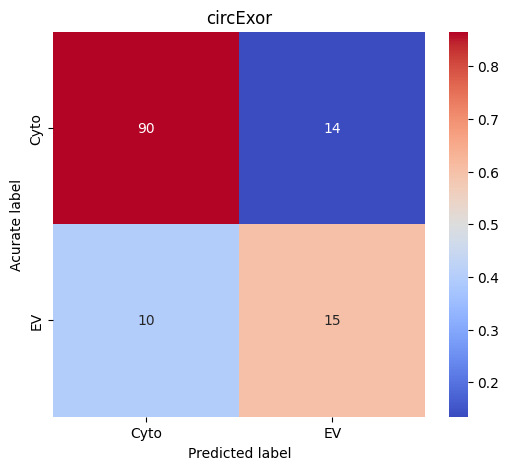

In [ ]:
cm = confusion_matrix(evaluate_df['tag'], evaluate_df['prediction'])
cm_normalized = normalize(cm, norm='l1', axis=1)

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='coolwarm', xticklabels=['Cyto', 'EV'], yticklabels=['Cyto', 'EV'])
plt.title('circExor')
plt.ylabel('Acurate label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# 反事实突变，EV kmer突变
model = load_model('/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/circExor/models/saved_models/circRNA_ML_Model_Output/LightGBM/best_LightGBM_model.pkl')
df = parse_fasta_to_dataframe('/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/python_scripts/SHAP/test_set_sequences1_mutated.fasta')
x_test = preprocess_data(df)
evaluate_df = predict(model, x_test, df)

/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


AUROC: 0.7823
Accuracy: 0.8140
Sensitivity: 0.4000
Specificity: 0.9135
F1 Score: 0.4545


/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


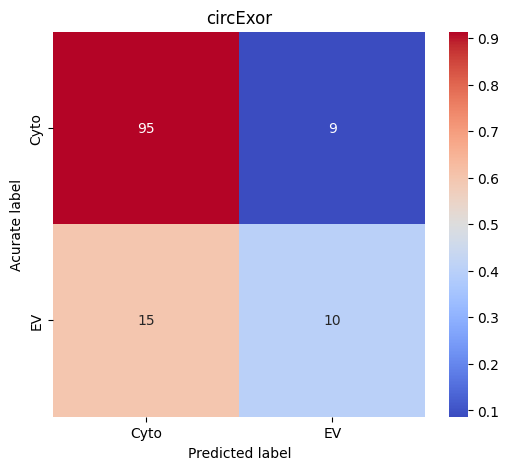

In [22]:
cm = confusion_matrix(evaluate_df['tag'], evaluate_df['prediction'])
cm_normalized = normalize(cm, norm='l1', axis=1)

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='coolwarm', xticklabels=['Cyto', 'EV'], yticklabels=['Cyto', 'EV'])
plt.title('circExor')
plt.ylabel('Acurate label')
plt.xlabel('Predicted label')
plt.show()


In [23]:
# 反事实突变，cyto kmer突变
model = load_model('/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/circExor/models/saved_models/circRNA_ML_Model_Output/LightGBM/best_LightGBM_model.pkl')
df = parse_fasta_to_dataframe('/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/python_scripts/SHAP/test_Cyto_sequences1_mutated.fasta')
x_test = preprocess_data(df)
evaluate_df = predict(model, x_test, df)

/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


AUROC: 0.7450
Accuracy: 0.7984
Sensitivity: 0.4800
Specificity: 0.8750
F1 Score: 0.4800


/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/BioII/lulab_b/huangkeyun/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


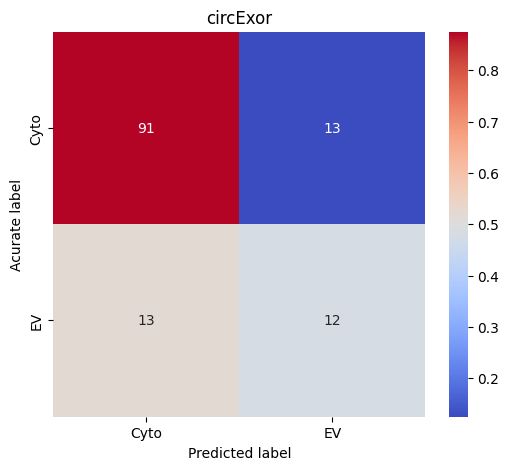

In [24]:
cm = confusion_matrix(evaluate_df['tag'], evaluate_df['prediction'])
cm_normalized = normalize(cm, norm='l1', axis=1)

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='coolwarm', xticklabels=['Cyto', 'EV'], yticklabels=['Cyto', 'EV'])
plt.title('circExor')
plt.ylabel('Acurate label')
plt.xlabel('Predicted label')
plt.show()